In [1]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

# Упражнения к главе 4
## Упражнение 4.1
Скачать звуки природных источников шума и вычислись спектры каждого сигнала. Определить похож ли спект мощностей на белый, розовый или броуновский шум и как спектр меняется во времени.
Были взяты записи с сайта asoftmurmur.com

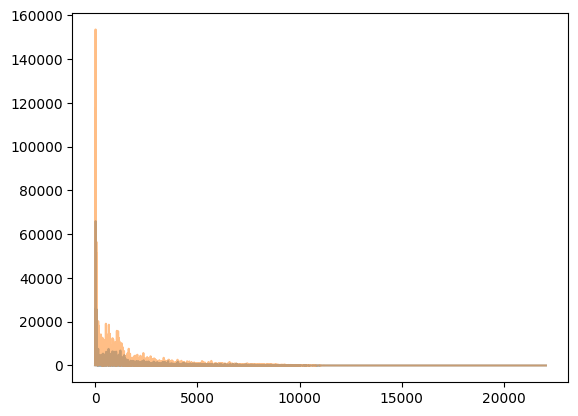

In [6]:
from thinkdsp import read_wave

rain_wave = read_wave("main-rain.wav")
wave_wave = read_wave("glue-waves.wav")

rain_spectrum1 = rain_wave.segment(2, 1).make_spectrum()
rain_spectrum2 = rain_wave.segment(10, 1).make_spectrum()

wave_spectrum1 = wave_wave.segment(1, 1).make_spectrum()
wave_spectrum2 = wave_wave.segment(4, 1).make_spectrum()

rain_spectrum1.plot_power(alpha=0.5)
rain_spectrum2.plot_power(alpha=0.5)

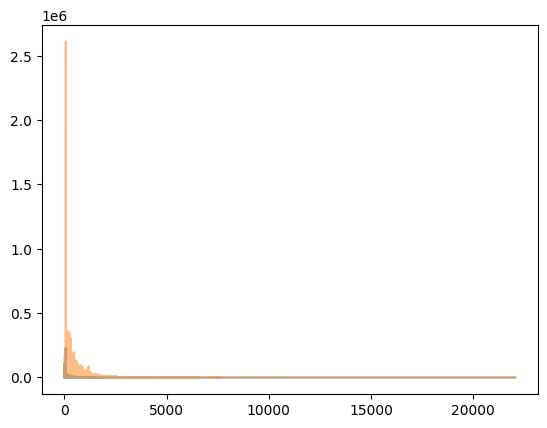

In [7]:
wave_spectrum1.plot_power(alpha=0.5)
wave_spectrum2.plot_power(alpha=0.5)

Заметно, что с переходом к более поздному сегменту увеличивается амплитуда

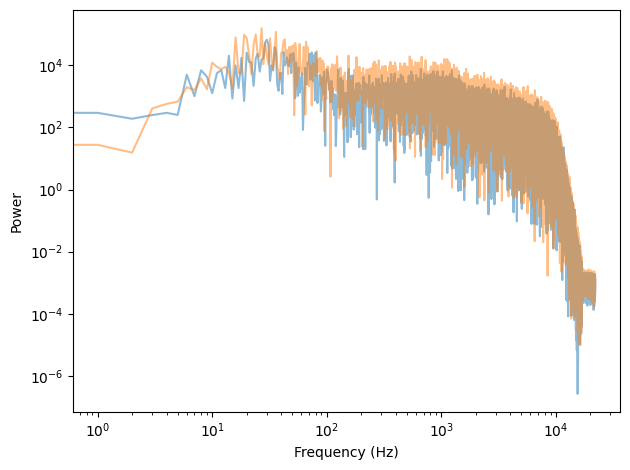

In [8]:
loglog = dict(xscale='log', yscale='log')
rain_spectrum1.plot_power(alpha=0.5)
rain_spectrum2.plot_power(alpha=0.5)
decorate(xlabel='Frequency (Hz)',
         ylabel='Power',
         **loglog)

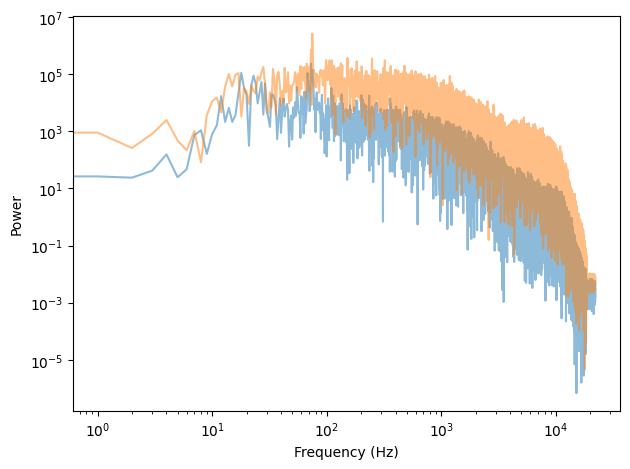

In [9]:
wave_spectrum1.plot_power(alpha=0.5)
wave_spectrum2.plot_power(alpha=0.5)
decorate(xlabel='Frequency (Hz)',
         ylabel='Power',
         **loglog)

Структура шума по времени достаточно постоянна, близка к розовому шуму.

## Упражнение 4.2
Реализовать метод Бартлетта и использовать его для оценки спектра мощности шумовой сигнала.

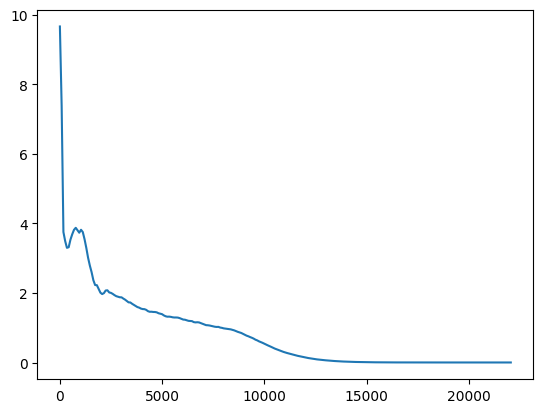

In [11]:
from thinkdsp import Spectrum

def bartlett_spectrum(wave, seg_length=512, win_flag=True):
    spectrogram = wave.make_spectrogram(seg_length, win_flag)
    spectrums = spectrogram.spec_map.values()
    psds = [spectrum.power for spectrum in spectrums]
    hs = np.sqrt(sum(psds) / len(psds))
    fs = next(iter(spectrums)).fs
    spectrum = Spectrum(hs, fs, wave.framerate)
    return spectrum

rain_bartlett = bartlett_spectrum(rain_wave)
rain_bartlett.plot()

## Упражнение 4.3.
Открыть данные об истории стоимости BitCoin и вычислить спект цен как функцию во времени. Определить похоже ли это на белый, розовый или броуновский шум.

C:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


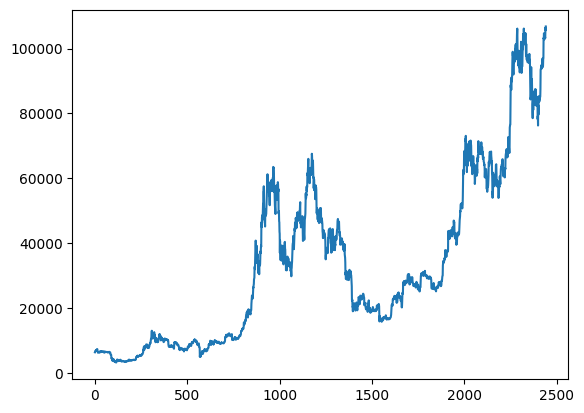

In [19]:
import pandas as pd
from thinkdsp import Wave

df = pd.read_excel('bitcoin.xlsx')
ys = list(df['priceClose'])
ts = list(df.index)
ts.reverse()

btc_wave = Wave(ys, ts, framerate=1)
btc_wave.plot()

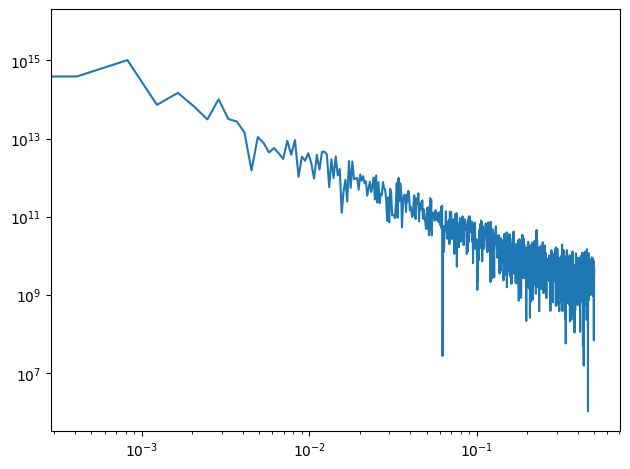

In [21]:
btc_wave.make_spectrum().plot_power()
decorate(**loglog)

In [22]:
btc_wave.make_spectrum().estimate_slope()[0]

-1.7856238676926015

Угол наклона спектра больше -2, поэтому сигнал является розовым шумом.

## Упражнение 4.4
Написать класс, называемый UncorrelatedPoissonNoise, наследующий thinkdsp._Noise и предоставляющий evaluate. Сгенерировать пару секунд UP, прослушать и посмотреть, что для малых значений amp звук будет как у счетчика Гейгера, а при больших - как белый шум. Вычислить и напечатать спектр мощности.

Writing low_freq_up.wav


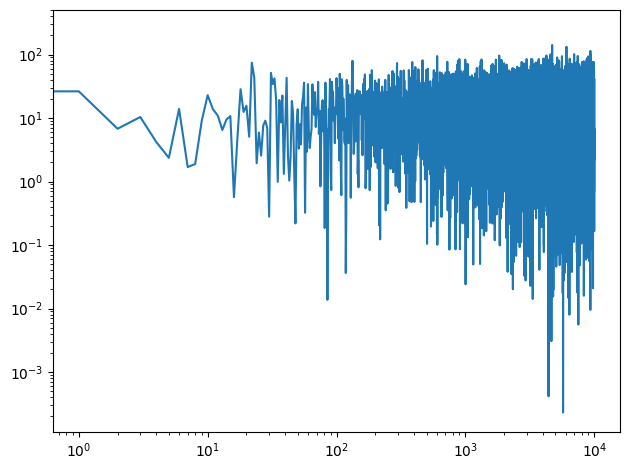

In [31]:
from thinkdsp import Noise

class UncorrelatedPoissonNoise(Noise):
    def evaluate(self, ts):
        return np.random.poisson(self.amp, len(ts))

low_freq = UncorrelatedPoissonNoise(amp=0.001).make_wave(duration=1, framerate=20000)
low_freq.apodize()
low_freq.make_spectrum().plot_power()
low_freq.write("low_freq_up.wav")
decorate(**loglog)

Writing high_freq_up.wav


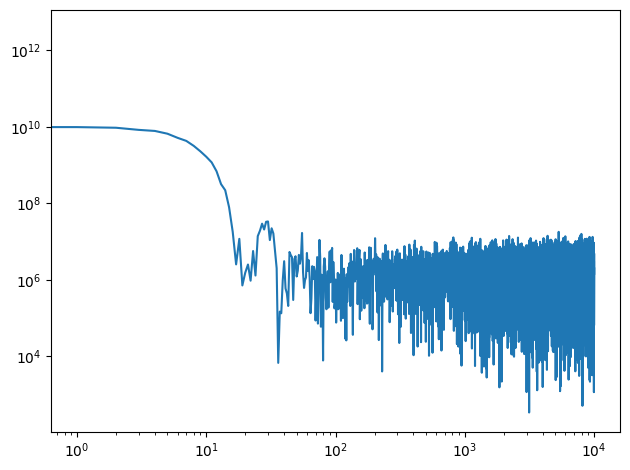

In [33]:
high_freq = UncorrelatedPoissonNoise(amp=100).make_wave(duration=1, framerate=20000)
high_freq.apodize()
high_freq.make_spectrum().plot_power()
high_freq.write("high_freq_up.wav")
decorate(**loglog)

Спектры в двойном логарифмическом масштабе практически горизонтальные, шум близок к белому.

## Упражнение 4.5
Изучить алгоритм Voss-McCartney для генерации розового шума, реализовать его, вычислить спектр результата и убедиться, что соотношение между мощностью и частотой соответствующее.
Суть алгоритма: сложение последовательностей случайных чисел с разными частотами дискретизации.

C:\Users\andre\AppData\Local\Temp\ipykernel_10604\3596282660.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', axis=0, inplace=True)


-0.9990686190388621

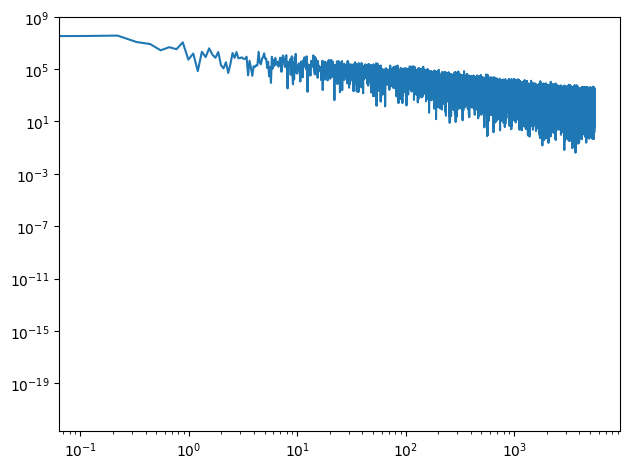

In [34]:
from thinkdsp import Wave

def voss_mccartney(nrows, ncols=16):
    array = np.empty((nrows, ncols))
    array.fill(np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)
    df = pd.DataFrame(array)
    df.fillna(method='ffill', axis=0, inplace=True)
    total = df.sum(axis=1)
    wave = Wave(total)
    wave.unbias()
    wave.normalize()
    return wave

wave_voss = voss_mccartney(100000)
spectrum_voss = wave_voss.make_spectrum()
spectrum_voss.plot_power()
decorate(**loglog)
spectrum_voss.estimate_slope()[0]

Угол наклона близок к -1, значит генерируется розовый шум.